# Clasifición de recuperados y no recuperados utilizando SMOTE

A continuación vamos a balancear nuestro dataset (cantidad de autos recuperados vs. no recuperados) subsampleando la clase mayoritaria (autos no recuperados ~95%) y sobresampleando la clase minoritaria (autos recuperados ~5%).

## Preparación y caracterización del dataset

In [1]:
# Cargamos las librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

In [2]:
# Cargamos los datos y dropeamos NaNs y una columna que quedó de más
data_total = pd.read_csv('./curados/ULTIMATE_DATASET.csv')
data_total.dropna(inplace=True) # Dropeamos NaNs
data_total.drop(['Unnamed: 0'], axis=1, inplace=True) # Dropeamos una columna extra

In [3]:
# Vemos cuántas denuncias de robo hay (es decir, cuántos no recuperados) y cuántas notificaciones
# de recupero hay (es decir, recuperados)
print("Hay "+ str(data_total['tramite_tipo'].value_counts()[0])+ ' no recuperados y '+
              str(data_total['tramite_tipo'].value_counts()[1])+ ' recuperados')
print("El porcentaje de recuperados en el dataset es "+ 
      str(round(data_total['tramite_tipo'].value_counts()[1]/data_total['tramite_tipo'].value_counts()[0],3)*100)+ ' %')

Hay 59986 no recuperados y 2925 recuperados
El porcentaje de recuperados en el dataset es 4.9 %


In [4]:
#cambio los valores de la columna tramite_tipo apra que robado sea 0 y recuperado 1
data_total['tramite_tipo'] = data_total['tramite_tipo'].map({'DENUNCIA DE ROBO O HURTO': 0, 
                                                             'COMUNICACIÓN DE RECUPERO': 1})

# Y cambiamos el nombre de la columna a "recuperados" con 0 cuando no están recuperados y 1 cuando
# si fueron recuperados
data_total = data_total.rename(columns={'tramite_tipo':'recuperados'})

In [5]:
# List de las columnas
data_total.columns

Index(['recuperados', 'tramite_fecha', 'fecha_inscripcion_inicial',
       'registro_seccional_descripcion', 'registro_seccional_provincia',
       'automotor_origen', 'automotor_anio_modelo',
       'automotor_tipo_descripcion', 'automotor_marca_descripcion',
       'automotor_modelo_descripcion', 'automotor_uso_descripcion',
       'titular_tipo_persona', 'titular_domicilio_localidad',
       'titular_domicilio_provincia', 'titular_genero',
       'titular_anio_nacimiento', 'titular_pais_nacimiento', 'unico_duenio',
       'dia_anio'],
      dtype='object')

In [6]:
# Quitamos los que tienen Uso no declarado
data_total = data_total.loc[data_total['automotor_uso_descripcion']!='No declarado']

In [7]:
# Dropeamos las columnas 'registro_seccional_descripcion' y 'titular_domicilio_localidad' porque
# no las consideramos relevantes para la prediccioón
data_total.drop(['registro_seccional_descripcion', 'titular_domicilio_localidad',], 
                axis= 1, inplace = True)

In [8]:
# Convertimos las fechas a datetime64
data_total['tramite_fecha']             = pd.to_datetime(data_total['tramite_fecha'])
data_total['fecha_inscripcion_inicial'] = pd.to_datetime(data_total['fecha_inscripcion_inicial'])

In [9]:
# Creamos columnas con el día, mes y año de robo más una columna con el año de patentamiento
data_total['dia_robo'] = data_total['tramite_fecha'].apply(lambda x: int(x.isoweekday())) #lunes es 1, domingo 7
data_total['mes_robo'] = data_total['tramite_fecha'].apply(lambda x: int(x.month))
data_total['dia_del_anio'] = data_total['tramite_fecha'].apply(lambda x: int(x.timetuple().tm_yday))
data_total['anio_pat'] = data_total['fecha_inscripcion_inicial'].apply(lambda x: int(x.year))

In [10]:
# Una nueva columna que dice si el titular está radicado en la misma provincia que el auto
data_total['tit_radicado'] = ((data_total['registro_seccional_provincia']).apply(lambda x: x.upper()) == data_total['titular_domicilio_provincia']).astype(int)

In [11]:
# Finalmente dropeamos las columnas que utilizamos para crear estas columnas aucxiliares
data_total.drop(['tramite_fecha', 'fecha_inscripcion_inicial', 'titular_domicilio_provincia'], axis = 1, inplace= True)
data_total.head(3)

,recuperados,registro_seccional_provincia,automotor_origen,automotor_anio_modelo,automotor_tipo_descripcion,automotor_marca_descripcion,automotor_modelo_descripcion,automotor_uso_descripcion,titular_tipo_persona,titular_genero,titular_anio_nacimiento,titular_pais_nacimiento,unico_duenio,dia_anio,dia_robo,mes_robo,dia_del_anio,anio_pat,tit_radicado
0,0,Buenos Aires,Nacional,2000.0,SEDAN 4 P,CHEVROLET,CORSA,Privado,Física,Masculino,1981.0,ARGENTINA,1,17,3,1,17,2000,1
1,0,Buenos Aires,Nacional,2007.0,FURGON,PEUGEOT,PARTNER,Privado,Física,Femenino,1990.0,ARGENTINA,1,3,3,1,3,2007,1
2,0,Buenos Aires,Nacional,1995.0,SEDAN 4 P,RENAULT,RENAULT 19,Privado,Física,Masculino,1986.0,ARGENTINA,1,12,5,1,12,1995,1


A continuación vamos a generar los dummies correspondientes a las columnas que utilizaremos en los modelos de predicción.

In [12]:
prov_dummie     = pd.get_dummies(data_total.registro_seccional_provincia)
tipo_dummie     = pd.get_dummies(data_total.automotor_tipo_descripcion)
marca_dummie    = pd.get_dummies(data_total.automotor_marca_descripcion)
modelo_dummie   = pd.get_dummies(data_total.automotor_modelo_descripcion)
uso_dummie      = pd.get_dummies(data_total.automotor_uso_descripcion)
pais_tit_dummie = pd.get_dummies(data_total.titular_pais_nacimiento)
# MARCA NO LA NECESITAMOS, CON MODELO YA TENÉS MARCA

In [13]:
# Correción de algunos dummies
tipo_dummie  = tipo_dummie.rename(columns={'PICK UP':'PICK UP tipo'})
marca_dummie = marca_dummie.rename(columns={'A.F.F.':'A.F.F. marca', 'PICK UP':'PICK UP marca', 'JEEP':'JEEP marca', 'RENAULT':'RENAULT marca'})
#data_total  = data_total.join([prov_dummie, origen_dummie, tipo_dummie,  modelo_dummie, uso_dummie, pais_tit_dummie, marca_dummie]) #marca_dummie,

In [14]:
# Creamos dummies para las variables con dos niveles
data_total['titular_pers_fisica'] = np.where(data_total['titular_tipo_persona'] == 'Física', 1, 0)
data_total['titular_masculino']   = np.where(data_total['titular_genero'] == 'Masculino', 1, 0)
data_total['importado']           = np.where(data_total['automotor_origen'] == 'Importado', 1, 0)

In [15]:
# Join con las dummies descartando la ultima columna
data_total = data_total.join([prov_dummie.iloc[:,:-1], marca_dummie.iloc[:,:-1],
                              tipo_dummie.iloc[:,:-1], modelo_dummie.iloc[:,:-1], 
                              uso_dummie.iloc[:,:-1], pais_tit_dummie.iloc[:,:-1]]) #marca_dummie,

In [16]:
# Dropeamos las columnas a partir de las cuales generamos los dummies
data_total.drop(['registro_seccional_provincia', 'automotor_origen', 'automotor_uso_descripcion','automotor_tipo_descripcion',
        'automotor_marca_descripcion', 'automotor_modelo_descripcion','titular_pais_nacimiento', 
       'titular_tipo_persona', 'titular_genero'], axis= 1, inplace = True)

In [17]:
np.shape(data_total)

(62842, 1993)

## Preparación de los datos para el ajuste del modelo

In [18]:
# Separación entre x e y
x = data_total.drop('recuperados', axis = 1)
y = data_total.recuperados

In [19]:
# Verifico que no haya NANs en x
np.where(np.isnan(x))

(array([], dtype=int64), array([], dtype=int64))

In [20]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)
print("La proporción de recuperados en el test es "+ str(round(ytest.sum()/np.shape(ytest)[0],2)))
print("La proporción de recuperados en el train es "+ str(round(ytrain.sum()/np.shape(ytrain)[0],2)))

La proporción de recuperados en el test es 0.05
La proporción de recuperados en el train es 0.05


Vemos que la proporción de recuperados es, aproximadamente, .05 en el train y el test set. Es decir, la estratificación funcionó bien.

## Auto-escaleo de las muestras

Antes de empezar a trabajar en el balanceo de las muestras, vamos a escalear el xtrain y xtest. De este modo, tanto cuando quitemos muestras como cuando creemos nuevas lo haremos en el espacio normalizado.

In [21]:
from sklearn import preprocessing

In [22]:
# Auto-escaleo de las muestras (mean = 0, std = 1)
scaler      = preprocessing.StandardScaler().fit(xtrain)
xtrain_scal = scaler.transform(xtrain)  
xtest_scal  = scaler.transform(xtest)  

## Balanceo de la muestra

### Undersampling con random

Vamos a balancear la muestra como para ver que entendemos el procedimiento, antes de empezar a ajutar cualquier modelo.

Lo primero que voy a hacer es probar randowm undersampling, es deir, borrar muestras de la majority al azar. Me quedo con N muestras, que en este caso lo puse como un tercio de los autos no recuperados.

In [23]:
# Mezclamos el dataset
shuffled_df = xtrain.sample(frac=1,random_state=4)

# Todos los recuperados por un lado
recup_df = xtrain.loc[ytrain == 1]
recup_df["recup"] = ytrain.loc[ytrain == 1]

# Los no recuperados por otro lado
no_recup_df = xtrain.loc[ytrain == 0]
no_recup_df["recup"] = ytrain.loc[ytrain == 0]

# Me quedo con N samples de los no recuperados
N = round(no_recup_df.shape[0]/3) # Me quedo con un tercio
no_recup_df = no_recup_df.sample(n=N,random_state=42)

In [24]:
undersampled_xtrain = pd.concat([recup_df, no_recup_df], ignore_index=True)
undersampled_ytrain = undersampled_xtrain["recup"]
undersampled_xtrain.drop('recup', axis=1, inplace=True)

In [25]:
print("La cantidad de muestras originales es " + str(xtrain.shape[0]))
print("La cantidad de muestras después del undersample es " + str(undersampled_xtrain.shape[0]))

La cantidad de muestras originales es 43989
La cantidad de muestras después del undersample es 16027


### Oversampling con SMOTE

SMOTE me permite aumentar el número de muestras de la minoría hasta una cierta proporción de la mayoría (dada en el código por *prop*).

In [26]:
from imblearn.over_sampling import SMOTE

prop = .5 # Es decir, la minería va a ser prop veces la mayoría

# Resampleo la minoría
sm = SMOTE(sampling_strategy=prop, random_state=7)

# Fiteo el modelo para generar la nueva data sintética
balanced_xtrain, balanced_ytrain = sm.fit_sample(undersampled_xtrain, undersampled_ytrain)

Using TensorFlow backend.


In [27]:
print("La cantidad de muestras originales (después del undersampling) es " + str(undersampled_xtrain.shape[0]))
print("La cantidad de muestras aumentadas es " + str(balanced_xtrain.shape[0]))

La cantidad de muestras originales (después del undersampling) es 16027
La cantidad de muestras aumentadas es 20971


In [28]:
print("La cantidad de recuperados originales (después del undersampling) es " + str(undersampled_ytrain.sum()))
print("La cantidad de recuperados aumentados es " + str(balanced_ytrain.sum()))

La cantidad de recuperados originales (después del undersampling) es 2046
La cantidad de recuperados aumentados es 6990


In [29]:
print("La proporción de recuperados en la muestra aumentada es " + 
      str(balanced_ytrain.sum()/balanced_xtrain.shape[0]))

La proporción de recuperados en la muestra aumentada es 0.33331743836726907


De esta forma logramos tener que 1 de cada 3 muestras sea de un auto recuperado.

Ahora que comprendemos como funcione el balanceo (random oversampling y SMOTe), tenemos que decidir cómo elegir la mejor combinación de parámetros para nuestro modelo. Como tenemos recursos (hardware y tiempo) limitados, vamos a hacer un barrido enre algunos posibles valores de los parámetros y vamos a ajustar un KNN para ver cual combinación mejora más la performance.

## KNN

Vamos a ajustar un KNN (con K de 1 a 10) para los datos originales y para versiones del dataset modificado modificando dos parámetros: la cantidad de muestras extraídas en el undersampling y la cantidad de muestras agregadas en el oversampling. Entre todas estas versiones del modelo nos vamos a quedar con el que maximice el Recall (una medida más confiable para muestras no balanceadas).

Para el undersampling nos vamos a quedar con el 25%, 50% y 75% de los autos no recuperados originales, y para cada uno de esos datasets vamos a hacer un SMOTe que iguales las proporciones de recuperados y no recuperados (*prop = 1*) o en el que la proporción de recuperados sea 0.5 (*prop =0.5*).

### KNN con los datos originales

In [30]:
from sklearn.metrics import accuracy_score, recall_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

In [31]:
# Creo un vector para guardar en recall del original
Ks = np.arange(1,10,1)
original_recall_knn = np.zeros(np.shape(Ks)[0])

In [32]:
# Corro el KNN con los datos originales
for r in Ks:
    # entreno un KNN classifier con "k=r+1"
    neigh = KNeighborsClassifier(n_neighbors=r)
    neigh.fit(xtrain,ytrain)
    # calculo la prediccion
    ypred_knn = neigh.predict(xtest)
    # guardo el resultado de prediccion en la posicion r del vector "acc_knn"
    original_recall_knn[r-1] = recall_score(ytest, ypred_knn)

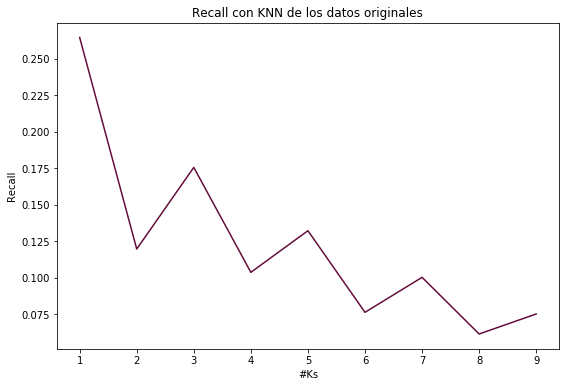

In [33]:
# Veamos el recall en función de K para los datos originales
customPalette = ['#630C3A', '#39C8C6', '#D3500C', '#FFB139']
plt.figure(figsize=(9,6))
plt.xlabel('#Ks')
plt.ylabel('Recall')
plt.title('Recall con KNN de los datos originales')
plt.plot(Ks,original_recall_knn,color=customPalette[0])
plt.savefig('./figs/Recalls_KNN.png')

In [34]:
# Cuál es el mejor recall en el KNN con los datos originales
max_recall = max(original_recall_knn)
max_K = Ks[np.argmax(original_recall_knn)]
print("El recall más grande es con " + str(round(max_recall,2))+ ' con '+ 
      str(max_K)+ ' neighbours')

El recall más grande es con 0.26 con 1 neighbours


En los datos originales el mayor recall da para k=2.

A continuación vamos a evaluar como se modifica el recall para las opciones de oversampling y undersampling antes descriptas.

In [35]:
# Dejamos fiteado el mejor KNN
best_KNN = KNeighborsClassifier(n_neighbors=max_K)
best_KNN.fit(xtrain,ytrain)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [38]:
# Verificamos la performance con el ytest (vemos la matriz de confusión)
ypred_knn = best_KNN.predict(xtest)
cm_knn    = confusion_matrix(ytest, ypred_knn)
print(cm_knn)

[[17385   591]
 [  645   232]]


In [39]:
print('El recall obtenido con el mejor KNN y el dataset original es de:',
      + round(recall_score(ytest, ypred_knn),2))
print('La accuracy obtenido con el mejor KNN y el dataset original es de:',
      + round(accuracy_score(ytest, ypred_knn),2))

El recall obtenido con el mejor KNN y el dataset original es de: 0.26
La accuracy obtenido con el mejor KNN y el dataset original es de: 0.93


Como es de esperarse para datos desbalanceados, el accuracy es alto pero el recall es bajo.

### KNN con los datos balanceados

In [40]:
# Creo las variables en las que voy a guardas los recalls

# Indicamos la cantidad de valores de balanceo que queremos probar
#      Undersampling
n_norecup = xtrain.loc[ytrain == 0].shape[0] # Cantidad de autos no recuperados
params_under = [n_norecup*.75, n_norecup*.5, n_norecup*.25] # Nos quedamos con 75%, 50% o 25% de 
                                                            # los no recuperados
#      Overrsampling
params_smote = [.5, 1] # Hacemos que los recuperados sean la mitad o la misma cantidad que los no
                      # recuperados
    
# Indicamos la cantidad de valores de K que queremos probar para cada combinación anterior
Ks = range(1,10)

# Creo un vector para guardar en recall para los datos balanceados
balanced_recall_knn = np.zeros([ np.shape(params_under)[0],  
                                 np.shape(params_smote)[0], 
                                 np.shape(Ks)[0]])

In [43]:
# Ahora voy a preprocesar y correr el KNN para cada combinación de 
# parámetros de under y oversampling
for idx_under in range(0,np.shape(params_under)[0]):
    for idx_smote in range(0,np.shape(params_smote)[0]):
        for r in Ks:
        
            ### UNDERSAMPLING ###

            # Mezclamos el dataset
            shuffled_df = xtrain.sample(frac=1,random_state=4)

            # Todos los recuperados por un lado
            recup_df = xtrain.loc[ytrain == 1]
            recup_df["recup"] = ytrain.loc[ytrain == 1]

            # Los no recuperados por otro lado
            no_recup_df = xtrain.loc[ytrain == 0]
            no_recup_df["recup"] = ytrain.loc[ytrain == 0]

            # Me quedo con N samples de los no recuperados
            no_recup_df = no_recup_df.sample(n=round(params_under[idx_under]),random_state=42)

            # Armo el x_train e y_train undersampleados
            undersampled_xtrain = pd.concat([recup_df, no_recup_df], ignore_index=True)
            undersampled_ytrain = undersampled_xtrain["recup"]
            undersampled_xtrain.drop('recup', axis=1, inplace=True)

            ### SMOTE ###

            # Creo el objeto de SMOTE
            sm = SMOTE(sampling_strategy=params_smote[idx_smote], random_state=42)

            # Fiteo el modelo para generar la nueva data sintética
            balanced_xtrain, balanced_ytrain = sm.fit_sample(undersampled_xtrain, undersampled_ytrain)

            ### KNN ###

            # entreno un KNN classifier con "k=r+1"
            neigh = KNeighborsClassifier(n_neighbors=r)
            neigh.fit(balanced_xtrain,balanced_ytrain)
            # calculo la prediccion
            ypred_knn = neigh.predict(xtest)
            # guardo el resultado de prediccion en la posicion r del vector "acc_knn"
            balanced_recall_knn[idx_under, idx_smote, r-1] = recall_score(ytest, ypred_knn)


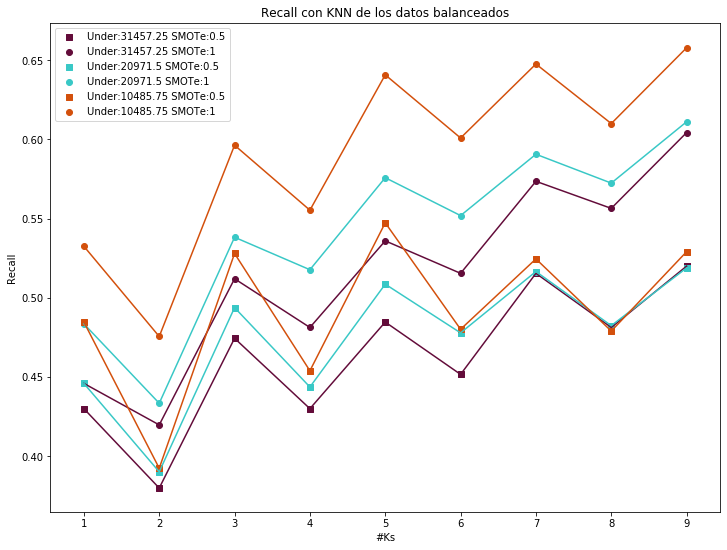

In [44]:
# Veamos el recall en función de K para los datos balanceados
markers = ['s', 'o']
plt.figure(figsize=(12,9))
plt.xlabel('#Ks')
plt.ylabel('Recall')
plt.title('Recall con KNN de los datos balanceados')
for idx_under in range(0,np.shape(params_under)[0]):
    for idx_smote in range(0,np.shape(params_smote)[0]):
        plt.plot(Ks, balanced_recall_knn[idx_under, idx_smote, :],
                 color=customPalette[idx_under])
        plt.scatter(Ks, balanced_recall_knn[idx_under, idx_smote, :],
                    color=customPalette[idx_under], marker=markers[idx_smote],
                    label='Under:'+ str(params_under[idx_under])+ ' SMOTe:' + str(params_smote[idx_smote]))
plt.legend()
plt.savefig('./figs/Recalls_SMOTe_KNN.png')

In [45]:
# Cuál es el mejor recall en el KNN con los datos balanceados
max_recall = np.amax(balanced_recall_knn)
max_under  = params_under[np.where(balanced_recall_knn == np.amax(balanced_recall_knn))[0][0]]
max_smote  = params_smote[np.where(balanced_recall_knn == np.amax(balanced_recall_knn))[1][0]]
max_K      = Ks[np.where(balanced_recall_knn == np.amax(balanced_recall_knn))[2][0]]

print("El recall más grande es con " + str(round(max_recall,2))+ 
      ' con '+ str(max_K)+ ' neighbours'+ 
      ', undersamplig a '+ str(max_under) + ' muestras'+
      ' y con una proporcion de SMOTE de '+ str(max_smote))

El recall más grande es con 0.66 con 9 neighbours, undersamplig a 10485.75 muestras y con una proporcion de SMOTE de 1


Como vemos que no llega a converger en número de Ks, vamos a tomar las opciones de SMOTe y undersampling con mejor performance y extender la simulación a K=100

In [46]:
# Primero creamos el balanced data con el mejor Fit

### UNDERSAMPLING ###

# Mezclamos el dataset
shuffled_df = xtrain.sample(frac=1,random_state=4)

# Todos los recuperados por un lado
recup_df = xtrain.loc[ytrain == 1]
recup_df["recup"] = ytrain.loc[ytrain == 1]

# Los no recuperados por otro lado
no_recup_df = xtrain.loc[ytrain == 0]
no_recup_df["recup"] = ytrain.loc[ytrain == 0]

# Me quedo con N samples de los no recuperados
no_recup_df = no_recup_df.sample(n=round(max_under),random_state=42)

# Armo el x_train e y_train undersampleados
undersampled_xtrain = pd.concat([recup_df, no_recup_df], ignore_index=True)
undersampled_ytrain = undersampled_xtrain["recup"]
undersampled_xtrain.drop('recup', axis=1, inplace=True)

### SMOTE ###

# Creo el objeto de SMOTE
sm = SMOTE(sampling_strategy=max_smote, random_state=42)

# Fiteo el modelo para generar la nueva data sintética
balanced_xtrain, balanced_ytrain = sm.fit_sample(undersampled_xtrain, undersampled_ytrain)

In [47]:
# Y ahora vamos a correr un loop en KNN
Ks = np.arange(10,110,10)
best_recall_knn = np.zeros(np.shape(Ks)[0])
for r in range(0, np.shape(Ks)[0]):
    # entreno un KNN classifier con "k=r+1"
    neigh = KNeighborsClassifier(n_neighbors=Ks[r])
    neigh.fit(balanced_xtrain,balanced_ytrain)
    # calculo la prediccion
    ypred_knn = neigh.predict(xtest)
    # guardo el resultado de prediccion en la posicion r del vector "acc_knn"
    best_recall_knn[r-1] = recall_score(ytest, ypred_knn)

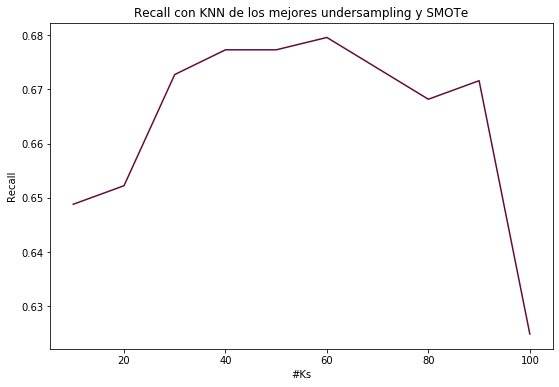

In [48]:
# Veamos el recall en función de K el best balanceado
plt.figure(figsize=(9,6))
plt.xlabel('#Ks')
plt.ylabel('Recall')
plt.title('Recall con KNN de los mejores undersampling y SMOTe')
plt.plot(Ks,best_recall_knn,color=customPalette[0])
plt.show()

In [49]:
print('El recall para k=10 es '+ str(round(best_recall_knn[0],3)))

El recall para k=10 es 0.649


Como parece que aumentando mucho el K o hay un gran aumento del recall, nos vamos a quedar ocnconverger a un valor de recall razonable, nos vamos a quedar con los *max_under*, *max_smote* y *max_K* definidos anteriormente para lo que sigue del ajuste.

In [50]:
# Dejamos fiteado el mejor KNN
best_KNN_bal = KNeighborsClassifier(n_neighbors=max_K)
best_KNN_bal.fit(balanced_xtrain,balanced_ytrain)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='uniform')

In [51]:
# Verificamos la performance con el ytest (vemos la matriz de confusión)
ypred_knn_bal = best_KNN_bal.predict(xtest)
cm_knn_bal = confusion_matrix(ytest, ypred_knn_bal)
print(cm_knn_bal)

[[12745  5231]
 [  300   577]]


In [52]:
print('El recall obtenido con el mejor KNN y el dataset balanceado es de:',
      + round(recall_score(ytest, ypred_knn_bal),2))
print('La accuracy obtenido con el mejor KNN y el dataset balanceado es de:',
      + round(accuracy_score(ytest, ypred_knn_bal),2))

El recall obtenido con el mejor KNN y el dataset balanceado es de: 0.66
La accuracy obtenido con el mejor KNN y el dataset balanceado es de: 0.71


## Random forest

### Random forest con los datos originales

Hacemos un Random Forest con los datos originales.

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [54]:
# Creamos el objeto Random Forest
rfc=RandomForestClassifier(random_state=42)
# Hacemos un gridsearch
param_grid = { 
    'n_estimators': [20,50],
    'max_features': ['sqrt', 'log2'],
    'max_depth'   : [40],
    'criterion'   : ['gini']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(xtrain, ytrain)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'

In [55]:
# Los mejores parámetros del Random Forest son
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 40,
 'max_features': 'sqrt',
 'n_estimators': 50}

In [56]:
# Finalmente ajusatmos le mejor modelo
rfc1=RandomForestClassifier(random_state = 42, 
                            max_features = CV_rfc.best_params_['max_features'], 
                            n_estimators = CV_rfc.best_params_['n_estimators'], 
                            max_depth    = CV_rfc.best_params_['max_depth'], 
                            criterion    = CV_rfc.best_params_['criterion'])
rfc1.fit(xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=40, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [57]:
# Verificamos la performance con el ytest (vemos la matriz de confusión)
ypred_rf = CV_rfc.predict(xtest)
cm_rf = confusion_matrix(ytest, ypred_rf)
print(cm_rf)

[[17907    69]
 [  508   369]]


In [58]:
print('El recall obtenido con el mejor Random Forest y el dataset original es de:',
      + round(recall_score(ytest, ypred_rf),2))
print('La accuracy obtenido con el mejor Random Forest y el dataset original es de:',
      + round(accuracy_score(ytest, ypred_rf),2))

El recall obtenido con el mejor Random Forest y el dataset original es de: 0.42
La accuracy obtenido con el mejor Random Forest y el dataset original es de: 0.97


Como es de esperarse, el accuracy da muy bien pero el recall da muy mal (algo típico en datasets dsbalanceados).

### Random forest con los datos balanceados

Ahora vamos a ajustar un Random Forest con los datos balanceados (el mejor balanceo) obtenido anteriormente.

In [59]:
# Creamos el objeto Random Forest
rfc=RandomForestClassifier(random_state=42)
# Hacemos un gridsearch
param_grid = { 
    'n_estimators': [20,50],
    'max_features': ['sqrt', 'log2'],
    'max_depth'   : [40],
    'criterion'   : ['gini']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(balanced_xtrain, balanced_ytrain)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'

In [60]:
# Los mejores parámetros del Random Forest son
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 40,
 'max_features': 'sqrt',
 'n_estimators': 50}

In [61]:
# Finalmente ajusatmos le mejor modelo
rfc1=RandomForestClassifier(random_state = 42, 
                            max_features = CV_rfc.best_params_['max_features'], 
                            n_estimators = CV_rfc.best_params_['n_estimators'], 
                            max_depth    = CV_rfc.best_params_['max_depth'], 
                            criterion    = CV_rfc.best_params_['criterion'])
rfc1.fit(balanced_xtrain, balanced_ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=40, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [63]:
# Verificamos la performance con el ytest (vemos la matriz de confusión)
ypred_rf_bal = CV_rfc.predict(xtest)
cm_rf_bal = confusion_matrix(ytest, ypred_rf_bal)
print(cm_rf_bal)

[[17639   337]
 [  414   463]]


In [64]:
print('El recall obtenido con el mejor Random Forest y el dataset balanceado es de:',
      + round(recall_score(ytest, ypred_rf_bal),2))
print('La accuracy obtenido con el mejor KNN y el dataset balanceado es de:',
      + round(accuracy_score(ytest, ypred_rf_bal),2))

El recall obtenido con el mejor Random Forest y el dataset balanceado es de: 0.53
La accuracy obtenido con el mejor KNN y el dataset balanceado es de: 0.96


El recall da peor que en el KNN pero el accuracy da mucho mejor. Habría que analizar qué significa esto para nuestro problema.

### Random Forest con PCA

Vamos a probar hacer un Random Forest con el dataset balanceado. Para esto empezamos ajustando un PCA con el dataset balanceado.

In [65]:
from sklearn.decomposition import PCA
# Cantidad de componentes a extraer
n_comps = 5
# Definimos PCA
pca = PCA(n_components= n_comps)
# Fit_transform del PCA a nuestros datos
xpca = pd.DataFrame(pca.fit_transform(balanced_xtrain))
# Obtenemos los auto-valores
eigenvalues = pca.explained_variance_ratio_

In [66]:
print('Las cinco componentes explican el '+ str(round(sum(eigenvalues)*100,2))+ '% de la varianza')

Las cinco componentes explican el 99.98% de la varianza


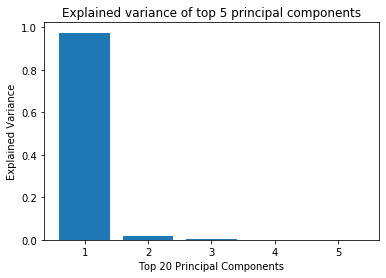

In [67]:
# Una figura que muestra la varianza explicada por cada componente
components = range(1,n_comps + 1)
plt.bar(components,eigenvalues)
plt.xticks(components)
plt.title('Explained variance of top 5 principal components')
plt.xlabel('Top 20 Principal Components')
plt.ylabel('Explained Variance')
plt.show()

Ahora sí vamos a ajustar el Random Forest y ver cuánto cambia la performance.

In [68]:
# Random Forest con PCA
rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [20,50],
    'max_features': ['sqrt', 'log2'],
    'max_depth'   : [40],
    'criterion'   : ['gini']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(xpca, balanced_ytrain)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'

In [69]:
# Tranformamos el xtest al espacio del PCA
xpca_test = pd.DataFrame(pca.fit_transform(xtest))

In [70]:
# Verificamos la performance con el ytest (vemos la matriz de confusión)
ypred_rf_pca = CV_rfc.predict(xpca_test)
cm_rf_pca = confusion_matrix(ytest, ypred_rf_pca)
print(cm_rf_pca)

[[8328 9648]
 [ 203  674]]


In [71]:
print('El recall obtenido con el mejor Random Forest, PCA y el dataset balanceado es de:',
      + round(recall_score(ytest, ypred_rf_pca),2))
print('La accuracy obtenido con el mejor Random Forest, PCA y el dataset balanceado es de:',
      + round(accuracy_score(ytest, ypred_rf_pca),2))

El recall obtenido con el mejor Random Forest, PCA y el dataset balanceado es de: 0.77
La accuracy obtenido con el mejor Random Forest, PCA y el dataset balanceado es de: 0.48


En este caso sube el recall de nuevo pero con el costo de bajar también el accuracy.